# Project 2 - Part 1


# Outline


- [Task 1](#task-1): Classification with a Convolutional Neural Network <a name="index-task-1"></a>
  - [(1.1)](#task-11) <a name="index-task-11"></a>
  - [(1.2)](#task-12) <a name="index-task-12"></a>
  - [(1.3)](#task-13) <a name="index-task-13"></a>
- [Task 2](#task-2): Dimensionality Reduction: PCA vs ISOMAP <a name="index-task-2"></a>
  - [(2.1)](#task-21)
  - [(2.2)](#task-22)
  - [(2.3)](#task-23)  



---



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import torch
import cmap

# Importing losses, activation functions and layers from PyTorch 
from scipy.sparse import linalg
from torch.nn import Sequential, CrossEntropyLoss, Conv1d, Conv2d, MaxPool2d, Flatten, Linear, ReLU, Softmax, Parameter
from torch.utils.data import TensorDataset, DataLoader

plt.rcParams['figure.figsize'] = [8.0, 8.0]
plt.rcParams['figure.dpi'] = 100



<a name="task-11"></a>

## (1.1) [(index)](#index-task-11)

In [2]:
cmap2 = cmap.Colormap('tab10')

<a name="task-1"></a>

# (1) Task 1: Classification with a Convolutional Neural Network [(index)](#index-task-1)

In this Question we shall implement a CNN and train it to predict the classes of our data set. We shall train the model by utilising a training and validation set and employ the use of Cross Entropy Loss as our loss function and will be utilising a fixed seed to ensure reproducability of our results. We have also incorporated early stopping into our model to prevent overfitting to our training set and result in our model failing to generalise well when exposed to unseen data. Early stopping also serves a secondary purpose throughout this notebook as to save computational resources when training models with minimal improvement.

Load the Data

In [3]:
s_image_train = np.load('star_images_train(1).npy')
s_class_train = np.load('star_classes_train(1).npy')

s_embed_train = np.load('star_embeddings_train(1).npy')

s_image_test = np.load('star_images_test(1).npy')
s_class_test = np.load('star_classes_test(1).npy')

# Implment a new axis to store channel depth
s_image_train = s_image_train[:,np.newaxis,:,:]

s_image_test = s_image_test[:,np.newaxis,:,:]

In [4]:
value_to_type = {0 : "O5V", 1: "A0V", 2 : "F5V", 3 : "M5V"}
color_type = [cmap2(i) for i in s_class_train]

Verify Data structure

In [5]:
print(s_image_train.shape)
print(s_class_train.shape)
print(s_embed_train.shape)
print(s_image_test.shape)
print(s_class_test.shape)


(648, 1, 32, 32)
(648,)
(648, 180)
(32, 1, 32, 32)
(32,)


In [6]:
classes = [
    'O5V',
    'A0V',
    'F5V',
    'M5V'
]

Split our Training Data Set into a Training and Validation Set

In [7]:
np.random.seed(0)

# Sample indices corresponding to data points without replacement to generate the training set indices
s_train_t_indices = np.random.choice(s_image_train.shape[0], size = int(s_image_train.shape[0]*3/4), replace = False )

# generate the validation set indices
s_train_v_indices = list(set(np.arange(s_image_train.shape[0])).difference(set(s_train_t_indices)))

# generate the training and validaiton sets
s_image_train_t = s_image_train[s_train_t_indices,:,:]
s_class_train_t = s_class_train[s_train_t_indices]
s_image_train_v = s_image_train[s_train_v_indices,:,:]
s_class_train_v = s_class_train[s_train_v_indices]

#Verify the shapes of the training and validation sets
print(s_image_train_t.shape,s_image_train_v.shape)

(486, 1, 32, 32) (162, 1, 32, 32)


Implement a function that generates the necessary model

In [8]:
def get_model(x_train, n_filters_1, n_filters_2, k, pool_size, stride_pool, classes, l2_reg=None, imbalanced_data = False, weights = 0):
    """
    CNN model in PyTorch:
    - Layers are Conv2d(+ReLU), MaxPool1d, Flatten and Linear(+Softmax).
    - It features an Adam optimiser and CrossEntropyLoss criterion.
    - Conv1d and Linear layers have regularised weights according to l2_reg.

    Parameters:
    x_train: Training data
    n_filters_1: Number of filters to be used in the first convolutional layer
    n_filters_2: Number of filters to be used in the second convolutional layer
    k: Kernel size in the convolutional layer
    pool_size: MaxPool2d window size
    stride_pool: Stride of the MaxPool2d sliding window
    classes: List containing the output classes
    l2_reg: Positive float corresponding to the regularisation coefficient of Conv1d and Linear
    imbalanced_data = Truth value denoting whether to adjust criterion uing the weights input
    weights = class weights used to adjust criterion

    Returns:
    Model, criterion and optimiser.

    """
    # Generate necessary values for layer inputs
    l_out_conv1 = x_train.shape[2] - k[0] + 1 
    h_out_conv1 = x_train.shape[3] - k[1] + 1                                     
    l_out_pool = (l_out_conv1 - pool_size[0]) // (stride_pool) + 1
    h_out_pool = (l_out_conv1 - pool_size[1]) // (stride_pool) + 1
    l_out_conv2 = l_out_pool - k[0] + 1
    h_out_conv2 = h_out_pool - k[1] + 1

    # Construct model layers
    model = Sequential(
        Conv2d(x_train.shape[1], n_filters_1, kernel_size=k),
        ReLU(),
        MaxPool2d(kernel_size=pool_size, stride=stride_pool), 
        Conv2d(n_filters_1, n_filters_2, kernel_size=k),
        ReLU(),
        Flatten(),
        Linear(l_out_conv2 * h_out_conv2 * n_filters_2, len(classes)), 
        Softmax(dim=1),
    )

    # Check if imbalanced Data
    if imbalanced_data:
        criterion = CrossEntropyLoss(weight = weights)
        
    else:
        criterion = CrossEntropyLoss()


    # check if l2_reg is to be conducted
        # if so, set up a prerequisite value to be used in the training loop
    if l2_reg:
        for layer in model.children():
            if isinstance(layer, Conv2d):
                layer.weight_regularizer = Parameter(np.sqrt(l2_reg) * torch.ones_like(layer.weight))

    optimiser = torch.optim.Adam(model.parameters())

    return model, criterion, optimiser

Initialise and Verify model structure

In [9]:
# Run your function to get the model and print it
n_filters1 = 4
n_filters2 = 8
k = (5,5)
pool_size = (2,2)
stride_pool = 2
l2_reg = 1e-3

model, criterion, optimiser = get_model(s_image_train_t, n_filters1, n_filters2, k, pool_size, stride_pool, classes)
print(model)

Sequential(
  (0): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Linear(in_features=800, out_features=4, bias=True)
  (7): Softmax(dim=1)
)


Define a function that generates our loaders to be used in the training loop

In [10]:
def loader_maker(x_train, y_train, x_val, y_val):
    """
    Function to create DataLoaders for training and validation datasets.

    Parameters:
    x_train: Training data
    y_train: Training labels
    x_val: Validation data
    y_val: Validation labels
    batch_size: Size of the mini-batches

    Returns:
    train_loader, val_loader: Training and validation DataLoaders
    """
    # Make data into tensors
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train)
    x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val)

    # Create datasets for training and vaidation
    train_dataset = TensorDataset(x_train_tensor, y_train_tensor.squeeze())
    val_dataset = TensorDataset(x_val_tensor, y_val_tensor.squeeze())

    # Creating corresponding DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

    return train_loader, val_loader

Implement early stopping

In [11]:
class EarlyStopping:
    """
    EarlyStopping class.

    Attributes:
    max_patience: Amount of epochs with no improvement after which training is stopped.
    patience: Stores the number of epochs with no improvement.
    best_valid_loss: Stores the current value of the best (minimum) validation loss.
    early_stop: True if training needs to be stopped due to the early stopping condition being met.

    Methods:
    step(val_loss):
        Checks current state after an epoch and updates best_loss, patience and early_stop accordingly.
    """

    def __init__(self, max_patience=150):
        self.max_patience = max_patience
        self.patience = 0
        self.best_valid_loss = float('inf')
        self.early_stop = False

    def step(self, val_loss):
        if val_loss < self.best_valid_loss:
            self.best_valid_loss = val_loss
            self.patience = 0
        else:
            self.patience += 1
            if self.patience >= self.max_patience:
                self.early_stop = True

Define a Training loop function to train our models

In [12]:
def training_loop(train_loader, val_loader, max_num_epochs=2000, max_patience=150, l2_reg = None):
    """
    Training loop with early stopping to monitor the validation accuracy.

    Parameters:
    train_loader: Training DataLoader
    val_loader: Validation DataLoader
    max_num_epochs: Maximum number of epochs
    max_patience: max_patience attribute of the EarlyStopping class
    l2_reg: the l2 regularisation parameter, if set to not None then L2 regularisation will be conducted using get_models specified l2_reg value

    Returns:
    Model, criterion and optimiser.

    """

    history = {'training_loss': [], 'validation_loss': [], 'training_accuracy': [], 'validation_accuracy': []}
    early_stopping = EarlyStopping(max_patience = max_patience)

    for epoch in range(max_num_epochs):

        tr_loss = 0.0
        tr_accuracy = 0
        val_loss = 0.0
        val_accuracy = 0

        # Training
        model.train()
        for inputs, labels in train_loader:
            # set grads to 0
            optimiser.zero_grad()
            outputs = model(inputs)
            
            # determine loss using our chosen loss function (the criterion)
            loss = criterion(outputs, labels)
            tr_loss += loss.item()

            # Determine if L2 regularisaiton is to be carried out
            if l2_reg:

                # Find Convolutional Layers
                for layer in model.children():
                    if isinstance(layer, Conv2d):

                        # Calculate the l2 term to be added to the loss function ensuring it is an autograd variable
                        x_loss = torch.square(torch.linalg.vector_norm(layer.weight_regularizer*layer.weight))

                        # add this value to the record of the loss function
                        tr_loss += x_loss.item()

                        # add this value to the loss term
                        loss += x_loss


            tr_accuracy +=  (torch.max(outputs, 1)[1] == labels).sum().item() / (len(train_loader) * labels.size(0))               
            loss.backward() # Computes gradients of the loss
            optimiser.step() # Optimisation step (parameters are updated)


        history['training_loss'].append(tr_loss/len(train_loader))
        history['training_accuracy'].append(100*tr_accuracy)

        # Validation
        model.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)

                # determine loss using our chosen loss function (the criterion)
                loss = criterion(outputs,labels)
                val_loss += loss.item()

                # Determine if L2 regularisaiton is to be carried out
                if l2_reg:
                    # Find Convolutional Layers
                    for layer in model.children():
                        if isinstance(layer, Conv2d):


                            # Calculate the l2 term to be added to the loss function ensuring it is an autograd variable
                            x_loss = torch.square(torch.norm(layer.weight_regularizer * layer.weight))

                            # add this value to the record of the loss function                          
                            val_loss += x_loss.item()
                            loss += x_loss

                            
                val_accuracy +=(torch.max(outputs, 1)[1] == labels).sum().item() / (len(val_loader) * labels.size(0))           

        history['validation_loss'].append(val_loss/len(val_loader))
        history['validation_accuracy'].append(100*val_accuracy)

        # Calculate accuracy and print
        if (epoch+1)%200 == 0:
            print(f"Epoch {epoch + 1}/{max_num_epochs}, Training loss: {tr_loss/len(train_loader)}, Training accuracy: {100*tr_accuracy}%, Validation loss: {val_loss/len(val_loader)}, Validation accuracy: {100*val_accuracy}%")


        early_stopping.step(val_loss / len(val_loader))
        if early_stopping.early_stop:

            print("Early stopping acting.")  
            break

    return history

Train a model on the split training data and check against our validation data. Plot the accuracy and cross entropy loss.

In [13]:
torch.manual_seed(0)

# Calling the training loop
max_num_epochs = 2000
patience = 150
model, criterion, optimiser = get_model(s_image_train_t, n_filters1, n_filters2, k, pool_size, stride_pool, classes)
train_loader1, val_loader1 = loader_maker(s_image_train_t, s_class_train_t,s_image_train_v, s_class_train_v)
history = training_loop(train_loader1, val_loader1, max_num_epochs, patience)

Epoch 200/2000, Training loss: 1.3076326251029968, Training accuracy: 40.47564338235294%, Validation loss: 1.3605915904045105, Validation accuracy: 33.84650735294118%
Epoch 400/2000, Training loss: 1.1451014280319214, Training accuracy: 63.24678308823529%, Validation loss: 1.1790637969970703, Validation accuracy: 55.46875%
Epoch 600/2000, Training loss: 1.0698617696762085, Training accuracy: 69.74571078431373%, Validation loss: 1.0944488048553467, Validation accuracy: 68.29044117647058%
Epoch 800/2000, Training loss: 1.0183720290660858, Training accuracy: 77.6156556372549%, Validation loss: 1.04855877161026, Validation accuracy: 70.93290441176471%
Epoch 1000/2000, Training loss: 0.9842380583286285, Training accuracy: 80.10876225490196%, Validation loss: 1.0178505778312683, Validation accuracy: 76.12591911764706%
Epoch 1200/2000, Training loss: 0.9544879496097565, Training accuracy: 83.24142156862744%, Validation loss: 0.9901560544967651, Validation accuracy: 79.75643382352942%
Epoch 14

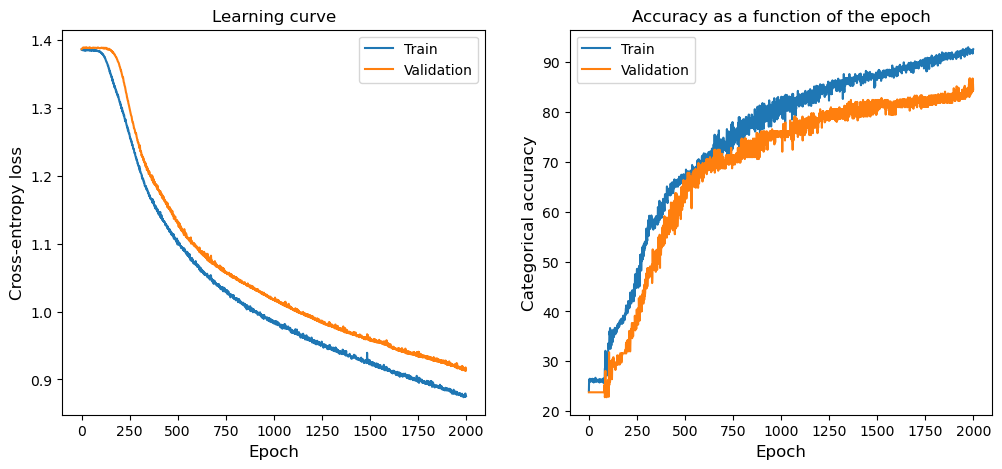

In [14]:
# Plot the learning curves

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)
plt.plot(history['training_loss'], label='Train')
plt.plot(history['validation_loss'], label='Validation')
plt.xlabel("Epoch", size=12)
plt.ylabel("Cross-entropy loss", size=12)
plt.title("Learning curve")
plt.legend()

fig.add_subplot(122)
plt.plot(history['training_accuracy'], label='Train')
plt.plot(history['validation_accuracy'], label='Validation')
plt.xlabel("Epoch", size=12)
plt.ylabel("Categorical accuracy", size=12)
plt.title("Accuracy as a function of the epoch")
plt.legend()

plt.show()

Get classification Accuracy on the Test Set

In [15]:
# Get test set predictions using the trained model
preds = model(torch.tensor(s_image_test, dtype=torch.float32)).detach().numpy() 

# Get class predictions
pred_class = np.argmax(preds, axis=1)

# Print the Test accuracy of the model
print('The test accuracy of the CNN model is:',100*np.sum(pred_class==s_class_test)/len(s_class_test))

The test accuracy of the CNN model is: 90.625


The behaviour of our training convergence demonstrates an initial period (around 100 epochs) of stagnation followed by a relatively fast training convergence up to approximately 65% training and validation accuracy at epoch 500, before ultimately slowing down and reaching a final training and validation accuracy of around 90% and 80% respectively.

The intially flat CEL is indicative of the training process searching for a descent direction due to the randomised initial weights. The steep improvement immediately after is due to the large disparity between the initial weights and the 'optimal' weights thus allowing for faster descent towards these the optimal weights. The decreasing Cross Entropy Loss tells us that more of its correct predictions are confident predictions. This is as cross entropy loss adds a value whenever a correct prediction is made, with a highr value being added if the confidence in this prediction is lower and a lower value added if the confidence is higher. Thus as the model makes fewer less confident correct predictions our cross entropy loss will decrease. It is important to note that Cross Entropy Loss doesn't directly take into account the number of incorrect predictions (although this will impact the number of correct predictinos that will then go on to affect the Cross Entropy Loss).

With regards to accuracy, our validation accuracy appears to converge to around 80% however we obeserve that the training accuracy continues to grow to 90% and shows signs of further increasing. This may be indicative of the model overfitting itself to the training data as it's ability to predict the validation data is not improving while it's ability to predict the training data is improving.

Our model returns a test data prediction accuracy of 90.625% which is relatively high when compared to our training accuracy and in particular our validation accuracy.  Noting that the test data is significantly smaller than our training and validation data sets, this may be indicative that this smaller data set has data with patterns that are more easily predicted by the model and with fewer 'outliers' when compared to our larger training and validation data sets.



---



<a name="task-12"></a>

## (1.2) [(index)](#index-task-12)

In this question we shall implement L2 regularisation into our model. This will be implemented to improve the classification accuracy of our model by attempting to reduce overfitting. We shall attempt to find an optimal L2 regularisation parameter from a given range of values using a fixed seed to ensure reproducability of our results.

Incorporate L2 regularisation into our model and find the optimal L2 regularisation parameter from a pregiven selection of parameters.

In [16]:
l2_vals = (0.001,0.01,0.1,1,10)

In [17]:
best_l = 0
best_accuracy = 0

for l in l2_vals:
    torch.manual_seed(102268774579500)
    #print(torch.seed())

    model, criterion, optimiser = get_model(s_image_train_t, n_filters1, n_filters2, k, pool_size, stride_pool, classes, l2_reg = l)
    train_loader1, val_loader1 = loader_maker(s_image_train_t, s_class_train_t,s_image_train_v, s_class_train_v)

    history = training_loop(train_loader1, val_loader1, max_num_epochs, patience, l2_reg=l)
    
    # Take the average validation accuracy of the last 10 epochs 
    accuracy = np.mean(history['validation_accuracy'][-10:])

    print(l,accuracy)

    if accuracy > best_accuracy:
        best_accuracy = accuracy 
        best_l = l

print(best_l, best_accuracy)

Epoch 200/2000, Training loss: 1.224534019464639, Training accuracy: 54.204963235294116%, Validation loss: 1.2445005210344724, Validation accuracy: 46.27757352941176%
Epoch 400/2000, Training loss: 1.0918796492406289, Training accuracy: 67.35600490196079%, Validation loss: 1.123673191715536, Validation accuracy: 60.36305147058824%
Epoch 600/2000, Training loss: 1.0338016196009505, Training accuracy: 74.82766544117648%, Validation loss: 1.0781395329862278, Validation accuracy: 69.66911764705883%
Epoch 800/2000, Training loss: 0.9908157423271851, Training accuracy: 83.04227941176471%, Validation loss: 1.050311143193042, Validation accuracy: 76.03400735294117%
Epoch 1000/2000, Training loss: 0.9624400750860269, Training accuracy: 85.68474264705883%, Validation loss: 1.0297053878307842, Validation accuracy: 73.09283088235294%
Epoch 1200/2000, Training loss: 0.9353444601408705, Training accuracy: 86.75704656862744%, Validation loss: 1.0057126353982433, Validation accuracy: 77.29779411764706

Train model using best regularisation parameter

In [18]:
torch.manual_seed(102268774579500)


model, criterion, optimiser = get_model(s_image_train_t, n_filters1, n_filters2, k, pool_size, stride_pool, classes,l2_reg = best_l)
train_loader3, test_loader3 = loader_maker(s_image_train_t, s_class_train_t,s_image_train_v, s_class_train_v)

history2 = training_loop(train_loader3, test_loader3, max_num_epochs, patience, l2_reg=best_l)

Epoch 200/2000, Training loss: 1.3332725399527305, Training accuracy: 36.50811887254902%, Validation loss: 1.3519387206750935, Validation accuracy: 35.40900735294118%
Epoch 400/2000, Training loss: 1.1241301024979815, Training accuracy: 64.27696078431373%, Validation loss: 1.1713185558470673, Validation accuracy: 59.283088235294116%
Epoch 600/2000, Training loss: 1.0428417979555438, Training accuracy: 74.97702205882352%, Validation loss: 1.0963662491136859, Validation accuracy: 68.29044117647058%
Epoch 800/2000, Training loss: 0.9788096068525336, Training accuracy: 84.65456495098039%, Validation loss: 1.0342054555597997, Validation accuracy: 78.07904411764706%
Epoch 1000/2000, Training loss: 0.9310274102413683, Training accuracy: 88.41911764705883%, Validation loss: 0.9902240701526885, Validation accuracy: 82.28400735294117%
Epoch 1200/2000, Training loss: 0.8955441916786985, Training accuracy: 90.8126531862745%, Validation loss: 0.9549356995690559, Validation accuracy: 83.754595588235

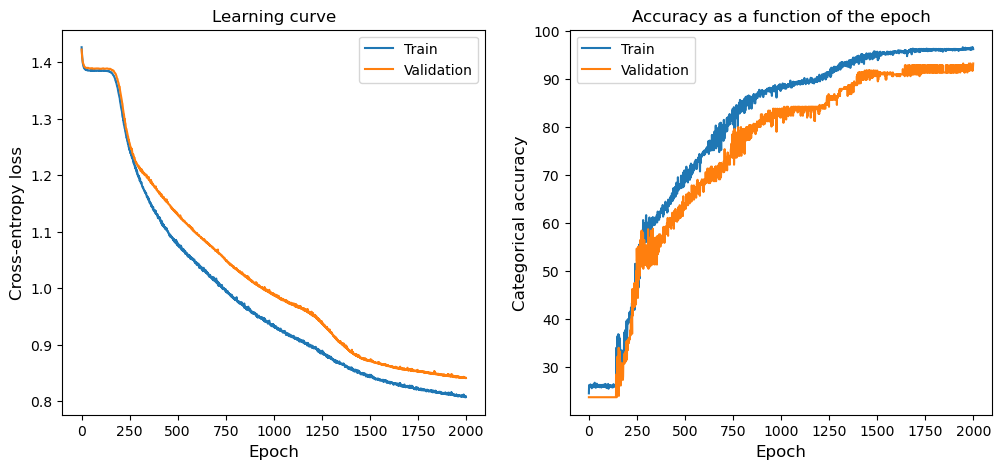

In [19]:
# Plot the learning curves

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)
plt.plot(history2['training_loss'], label='Train')
plt.plot(history2['validation_loss'], label='Validation')
plt.xlabel("Epoch", size=12)
plt.ylabel("Cross-entropy loss", size=12)
plt.title("Learning curve")
plt.legend()

fig.add_subplot(122)
plt.plot(history2['training_accuracy'], label='Train')
plt.plot(history2['validation_accuracy'], label='Validation')
plt.xlabel("Epoch", size=12)
plt.ylabel("Categorical accuracy", size=12)
plt.title("Accuracy as a function of the epoch")
plt.legend()

plt.show()

In [20]:
# Get test set predictions using the trained model
preds = model(torch.tensor(s_image_test, dtype=torch.float32)).detach().numpy() 

# Get class predictions
pred_class = np.argmax(preds, axis=1)

# Print the Test accuracy of the model
print(f'The test accuracy of the CNN model with L2 regularisation using L2 parameter{best_l} is:',100*np.sum(pred_class==s_class_test)/len(s_class_test))

The test accuracy of the CNN model with L2 regularisation using L2 parameter0.01 is: 93.75


Using L2 regularisation with our optimal L2 regularisation parameter, we observe faster initial convergence with our model reaching 60% training and validation accuracy in approximately 300 epochs.

Our L2 regularisation model also converges to higher accuracies: validation accuracy appears to converge to around 90-93% while training accuracy appears to converge to around 96% when compared to the earlier stated accuracies from our 1.1 model and the reduced disparity between these convergence values suggests less overfitting compared to the model from 1.1 This may be explained by considering how L2 regularisation works in that it penalises large weights. This effectively prevents the model from overfitting to particular trends within the training dataset and becoming overly sensitive to small changes in the data. Furthermore, L2 regularisation discourages weights from hitting 0 by penalising smaller weights signicantly less than large ones.   

Our L2 regularisation CNN model also results in a higher test predicion accuracy(93.75% compared to Q1.1 models 90.625%) suggesting a better ability to predict unseen data when compared to the model from 1.1 and ultimately suggesting that our model employing L2 regularisation is better in this regard.



---



<a name="task-13"></a>

## (1.3) [(index)](#index-task-12)

In this question we shall explore the issues faced when attempting to classify an imbalanced data set using Neural networks. In particular we will consider the impact of an imbalanced data set when training a model without any further changes, and then we shall attempt to overcome the disadvantages of working with an imbalanced data set using two main approaches: weighted CNN and utilising an augumented data set. Weighted CNN shall attempt to fine tune our optimisation process by placing higher weights on the minority class and preventing trends within this class from being overlooked when training the model. Utilising an augumented data set will attempt compensate for the existence of a minority class by employing gaussian noise to generate new data points for this minority class using preexisting ones. In order to generate these new data points effectively, we will attempt to find an optimal varaince parameter for our given data set. We will then compare both of these models abilities to predict unseen data and we have utilised a fixed seed to ensure reproducability of results. 

Remove 50% of the data points in class 3 from the training set

In [21]:
np.random.seed(0)

s_image_train_h3 = s_image_train.copy()
s_class_train_h3 = s_class_train.copy()

# Find indices where data points class = 3
class3_indices = np.argwhere(s_class_train_h3 == 3).squeeze()

# Randomly pick half of these indices
#s_train_t_indices = np.random.choice(s_image_train.shape[0], size = int(s_image_train.shape[0]*3/4), replace = False )
half_class3_indices = np.random.choice(class3_indices, 80, replace = False)

# Find the data points off class 3 that are kept
kept_class3_indices = list(set(class3_indices).difference(set(half_class3_indices)))

# find data point indices excluding half of the indices where the class = 3
s_train_h3_indices = list(set(np.arange(s_image_train.shape[0])).difference(set(half_class3_indices)))

#Generate new training data set that doesn't include half of the training data
s_image_train_h3 = s_image_train_h3[s_train_h3_indices,:,:,:]
s_class_train_h3 = s_class_train_h3[s_train_h3_indices]


# Sample indices corresponding to data points without replacement to generate the training set indices
s_train_h3_t_indices = np.random.choice(s_image_train_h3.shape[0], size = int(s_image_train_h3.shape[0]*3/4), replace = False )

# generate the validation set indices
s_train_h3_v_indices = list(set(np.arange(s_image_train_h3.shape[0])).difference(set(s_train_h3_t_indices)))

# generate the training and validation sets
s_image_train_h3_t = s_image_train_h3[s_train_h3_t_indices,:,:]
s_class_train_h3_t = s_class_train_h3[s_train_h3_t_indices]
s_image_train_h3_v = s_image_train_h3[s_train_h3_v_indices,:,:]
s_class_train_h3_v = s_class_train_h3[s_train_h3_v_indices]

#Verify the shapes of the training and validation sets
print(s_image_train_h3_t.shape,s_class_train_h3_t.shape,s_image_train_h3_v.shape,s_class_train_h3_v.shape)

(426, 1, 32, 32) (426,) (142, 1, 32, 32) (142,)


Train a CNN on this data

In [22]:
torch.manual_seed(0)

model, criterion, optimiser = get_model(s_image_train_h3_t, n_filters1, n_filters2, k, pool_size, stride_pool, classes)
train_loader3, val_loader3 = loader_maker(s_image_train_h3_t, s_class_train_h3_t,s_image_train_h3_v, s_class_train_h3_v)

history3 = training_loop(train_loader3, val_loader3, max_num_epochs, patience)

Early stopping acting.


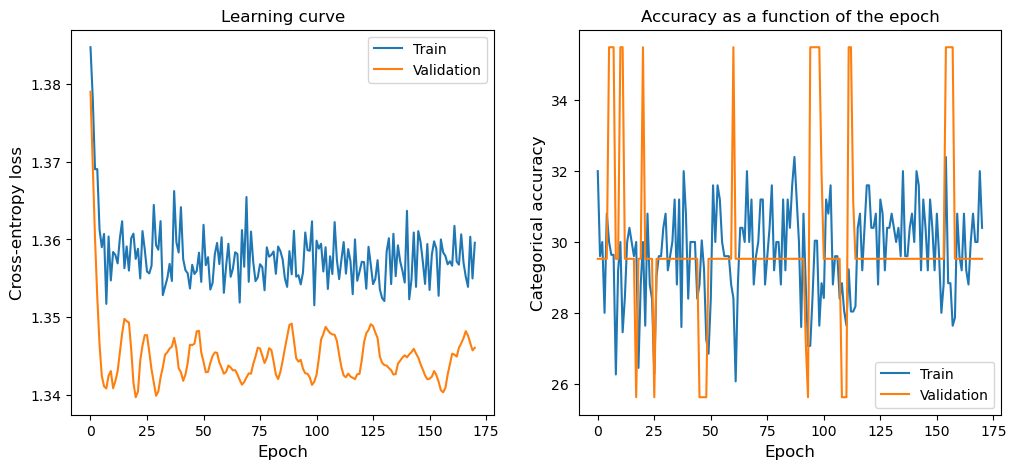

In [23]:
# Plot the learning curves

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)
plt.plot(history3['training_loss'], label='Train')
plt.plot(history3['validation_loss'], label='Validation')
plt.xlabel("Epoch", size=12)
plt.ylabel("Cross-entropy loss", size=12)
plt.title("Learning curve")
plt.legend()

fig.add_subplot(122)
plt.plot(history3['training_accuracy'], label='Train')
plt.plot(history3['validation_accuracy'], label='Validation')
plt.xlabel("Epoch", size=12)
plt.ylabel("Categorical accuracy", size=12)
plt.title("Accuracy as a function of the epoch")
plt.legend()

plt.show()

Modify the CNN loss function so that class 3 now has more weight

In [24]:
# Calculate class weights
class_sizes = np.bincount(s_class_train_h3_t)
class_weights = 1/class_sizes

class_weights_scaled = class_weights* len(s_class_train_h3_t)
class_weights_scaled_tensor = torch.tensor(class_weights_scaled).float()


class_weights_new = torch.tensor([1,1,1,2]).float()

Train a weighted CNN

In [25]:
torch.manual_seed(0)

model, criterion, optimiser = get_model(s_image_train_h3_t, n_filters1, n_filters2, k, pool_size, stride_pool, classes, imbalanced_data = True ,weights = class_weights_scaled_tensor )
train_loader5, val_loader5 = loader_maker(s_image_train_h3_t, s_class_train_h3_t,s_image_train_h3_v, s_class_train_h3_v)

history5 = training_loop(train_loader5, val_loader5, max_num_epochs, patience)

Epoch 200/2000, Training loss: 1.219633013010025, Training accuracy: 40.21577380952381%, Validation loss: 1.2663811445236206, Validation accuracy: 33.035714285714285%
Epoch 400/2000, Training loss: 1.1391675174236298, Training accuracy: 56.67782738095239%, Validation loss: 1.171832025051117, Validation accuracy: 55.13392857142857%
Epoch 600/2000, Training loss: 1.0966163277626038, Training accuracy: 62.33258928571428%, Validation loss: 1.1445116996765137, Validation accuracy: 57.86830357142857%
Epoch 800/2000, Training loss: 1.0675175189971924, Training accuracy: 65.69940476190477%, Validation loss: 1.1138606071472168, Validation accuracy: 61.04910714285714%
Epoch 1000/2000, Training loss: 1.0520916283130646, Training accuracy: 64.86235119047619%, Validation loss: 1.0910495519638062, Validation accuracy: 61.04910714285714%
Epoch 1200/2000, Training loss: 1.037423461675644, Training accuracy: 68.83370535714286%, Validation loss: 1.063984990119934, Validation accuracy: 62.61160714285714%

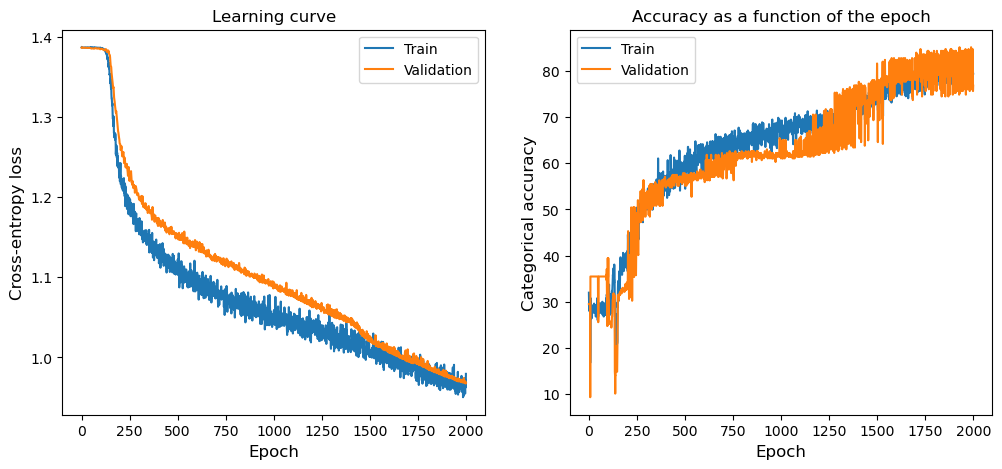

In [26]:
# Plot the learning curves

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)
plt.plot(history5['training_loss'], label='Train')
plt.plot(history5['validation_loss'], label='Validation')
plt.xlabel("Epoch", size=12)
plt.ylabel("Cross-entropy loss", size=12)
plt.title("Learning curve")
plt.legend()

fig.add_subplot(122)
plt.plot(history5['training_accuracy'], label='Train')
plt.plot(history5['validation_accuracy'], label='Validation')
plt.xlabel("Epoch", size=12)
plt.ylabel("Categorical accuracy", size=12)
plt.title("Accuracy as a function of the epoch")
plt.legend()

plt.show()

Get classification Accuracy on the Test Set

In [27]:
# Get test set predictions using the trained model
preds = model(torch.tensor(s_image_test, dtype=torch.float32)).detach().numpy() 

# Get class predictions
pred_class = np.argmax(preds, axis=1)

# Print the Test accuracy of the model
print('The test accuracy of the weighted CNN model is:',100*np.sum(pred_class==s_class_test)/len(s_class_test))

The test accuracy of the weighted CNN model is: 81.25


Generate a function that generates Noisy Data with minority class 3

In [28]:
def noisy_data(training_data, changed_indices, c):
    """
    A function that generates noisy data

    Inputs: 
        training_data: Data set
        changed_indices: indices to be have noise added to them
        c: parameter to adjust amount of variance in the noise


    Returns:
        noisy_changed_data: Data points with indices corresponding the changed_indices taken from the training_data with added gaussian noise dependent on c
    
    
    """
    
    
    changed_data= training_data[changed_indices,:,:,:]

    variances = np.var(changed_data, axis = 0).squeeze()
    #print(variances.shape)
    
    noisy_changed_data = np.zeros(changed_data.shape)

    for i in np.arange(changed_data.shape[0]) :
        noise = np.random.normal(np.zeros(variances.shape), np.sqrt(c*variances))
        #print(noise.shape)

        noisy_changed_data[i,:,:,:] = changed_data[i,0,:,:] + noise

    return noisy_changed_data


In [29]:
def augumented_data(training_data, changed_indices, c, class_data, removed_indices=[]):

    """
    A function that auguments our data

    Inputs: 
        training_data: Data set
        changed_indices: indices to be have noise added to them
        c: parameter to adjust amount of variance in the noise
        class_data: classes corresponding to training_data
        removed_indices: indices to be removed from the data


    Returns:
        noisy_changed_data: Data points with indices corresponding the changed_indices taken from the training_data with added gaussian noise dependent on c
    
    
    """

    # generate noisy data
    noisy_data_temp = noisy_data(training_data, changed_indices, c)
    noisy_data_classes = class_data[changed_indices]

    # Calculate kept indices
    kept_indices = list(set(np.arange(training_data.shape[0])).difference(set(removed_indices)))

    # generate adjusted data
    training_data = training_data[kept_indices,:,:,:]
    class_data = class_data[kept_indices]

    # replace corresponding indices with the generated noisy data
    training_data = np.vstack((training_data,noisy_data_temp))
    class_data = np.hstack((class_data,noisy_data_classes))

    return training_data, class_data

Determine Best C value

In [30]:
c_vals = (0.01,0.1,1)
best_c = 0
best_accuracy_c = 0

for c in c_vals:
    
    np.random.seed(0)
    torch.manual_seed(0)
    
    # generate augumented data
    augumented_data1 , augumented_classes1= augumented_data(s_image_train,kept_class3_indices,c, s_class_train , half_class3_indices )
    #augumented_data1 = augumented_data(s_image_train,kept_class3_indices,c)


    # generate indices for testing data points
    augumented_data1_t_indices = np.random.choice(augumented_data1.shape[0], size = int(augumented_data1.shape[0]*3/4), replace = False )
    # generate indices for training data points
    augumented_data1_v_indices = list(set(np.arange(augumented_data1.shape[0])).difference(set(augumented_data1_t_indices)))
    # generate test data and training data
    s_image_train_aug_t = augumented_data1[augumented_data1_t_indices,:,:,: ]
    s_class_train_aug_t = augumented_classes1[augumented_data1_t_indices]
    s_image_train_aug_v = augumented_data1[augumented_data1_v_indices,:,:,: ]
    s_class_train_aug_v = augumented_classes1[augumented_data1_v_indices]


    # generate model
    model, criterion, optimiser = get_model(s_image_train_aug_t, n_filters1, n_filters2, k, pool_size, stride_pool, classes)
    # generate loaded data
    train_loader_aug, val_loader_aug = loader_maker(s_image_train_aug_t, s_class_train_aug_t,s_image_train_aug_v, s_class_train_aug_v)
    # train the model
    history = training_loop(train_loader_aug, val_loader_aug, max_num_epochs, patience)
    
    # Get Validation accuracy of the trained model
    accuracy_c = np.mean(history['validation_accuracy'][-10:])

    # print the variance paraeter and the corresponding models validation accuracy
    print(c,accuracy_c)

    # Update best variance parameter if necessary
    if accuracy_c > best_accuracy_c:
        best_accuracy_c = accuracy_c 
        best_c = c

# Print the best variance parameter and the corresponding models validation accuracy
print(best_c, best_accuracy_c)

Epoch 200/2000, Training loss: 1.232887864112854, Training accuracy: 47.98943014705882%, Validation loss: 1.2775822281837463, Validation accuracy: 38.236607142857146%
Epoch 400/2000, Training loss: 1.1118340492248535, Training accuracy: 65.73606004901961%, Validation loss: 1.1432215571403503, Validation accuracy: 61.64062500000001%
Epoch 600/2000, Training loss: 1.066768765449524, Training accuracy: 69.40104166666666%, Validation loss: 1.095243215560913, Validation accuracy: 62.42187500000001%
Epoch 800/2000, Training loss: 1.0278304815292358, Training accuracy: 73.75536151960785%, Validation loss: 1.05753093957901, Validation accuracy: 68.40401785714285%
Epoch 1000/2000, Training loss: 0.9966063350439072, Training accuracy: 78.64200367647058%, Validation loss: 1.038288414478302, Validation accuracy: 70.61383928571429%
Epoch 1200/2000, Training loss: 0.9693222641944885, Training accuracy: 82.64782475490196%, Validation loss: 1.0126835405826569, Validation accuracy: 77.12053571428572%
E

Train model using best c (variance parameter)

In [31]:
np.random.seed(0)
torch.manual_seed(0)
    
# generate augumented data
augumented_data1 , augumented_classes1= augumented_data(s_image_train,kept_class3_indices,best_c, s_class_train , half_class3_indices )

# generate indices for testing data points
augumented_data1_t_indices = np.random.choice(augumented_data1.shape[0], size = int(augumented_data1.shape[0]*3/4), replace = False )
# generate indices for training data points
augumented_data1_v_indices = list(set(np.arange(augumented_data1.shape[0])).difference(set(augumented_data1_t_indices)))
# generate test data and training data
s_image_train_aug_t = augumented_data1[augumented_data1_t_indices,:,:,: ]
s_class_train_aug_t = augumented_classes1[augumented_data1_t_indices]
s_image_train_aug_v = augumented_data1[augumented_data1_v_indices,:,:,: ]
s_class_train_aug_v = augumented_classes1[augumented_data1_v_indices]


# generate model
model, criterion, optimiser = get_model(s_image_train_aug_t, n_filters1, n_filters2, k, pool_size, stride_pool, classes)
# generate loaded data
train_loader_aug, val_loader_aug = loader_maker(s_image_train_aug_t, s_class_train_aug_t,s_image_train_aug_v, s_class_train_aug_v)
# train the model
history_aug = training_loop(train_loader_aug, val_loader_aug, max_num_epochs, patience)

Epoch 200/2000, Training loss: 1.232887864112854, Training accuracy: 47.98943014705882%, Validation loss: 1.2775822281837463, Validation accuracy: 38.236607142857146%
Epoch 400/2000, Training loss: 1.1118340492248535, Training accuracy: 65.73606004901961%, Validation loss: 1.1432215571403503, Validation accuracy: 61.64062500000001%
Epoch 600/2000, Training loss: 1.066768765449524, Training accuracy: 69.40104166666666%, Validation loss: 1.095243215560913, Validation accuracy: 62.42187500000001%
Epoch 800/2000, Training loss: 1.0278304815292358, Training accuracy: 73.75536151960785%, Validation loss: 1.05753093957901, Validation accuracy: 68.40401785714285%
Epoch 1000/2000, Training loss: 0.9966063350439072, Training accuracy: 78.64200367647058%, Validation loss: 1.038288414478302, Validation accuracy: 70.61383928571429%
Epoch 1200/2000, Training loss: 0.9693222641944885, Training accuracy: 82.64782475490196%, Validation loss: 1.0126835405826569, Validation accuracy: 77.12053571428572%
E

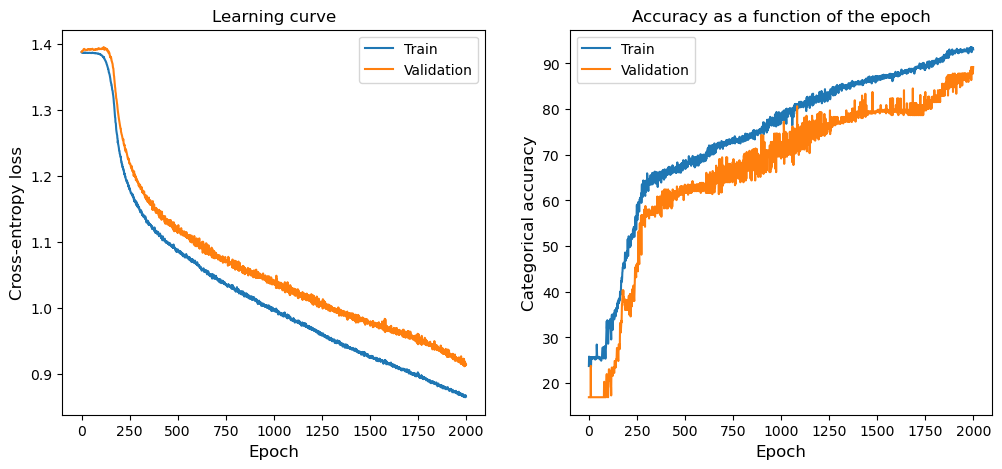

In [32]:
# Plot the learning curves

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)
plt.plot(history_aug['training_loss'], label='Train')
plt.plot(history_aug['validation_loss'], label='Validation')
plt.xlabel("Epoch", size=12)
plt.ylabel("Cross-entropy loss", size=12)
plt.title("Learning curve")
plt.legend()

fig.add_subplot(122)
plt.plot(history_aug['training_accuracy'], label='Train')
plt.plot(history_aug['validation_accuracy'], label='Validation')
plt.xlabel("Epoch", size=12)
plt.ylabel("Categorical accuracy", size=12)
plt.title("Accuracy as a function of the epoch")
plt.legend()

plt.show()

Get classification Accuracy on the Test Set

In [33]:
# Get test set predictions using the trained model
preds = model(torch.tensor(s_image_test, dtype=torch.float32)).detach().numpy() 

# Get class predictions
pred_class = np.argmax(preds, axis=1)

# Print the Test accuracy of the model
print('The test accuracy of the model trained on the augumented data set is:',100*np.sum(pred_class==s_class_test)/len(s_class_test))

The test accuracy of the model trained on the augumented data set is: 87.5


Our weighted CNN model returns a test accuracy of 81.25% while the test accuracy of the model trained on the augumented data set is 87.5% suggesting the model trained on the augmented data generalises better to unseen data.

When comparing the training of the two models, we observe that for the weighted CNN model our validation accuracy exhibits high volatility, particularily towards the the later epochs when the models validation accuracy appears to be converging. This behaviour is not exhibited by the model trained on the augumented data whose validation accuracy growth is more reminiscent of the trained models in 1.1 and 1.2. This high volatility observed by the weighted CNN may be indicative of the model overcorrecting itself when attempting to optimise its parameters due to higher penalties applied to misclassifications of the minority class. This ourlines a major issue with emplyoing weighted CNN in that we have to detrermine what weights to use for the training process. Data augumentation attempts to overcome the issue of having a minority class by generating new minority class values through applying noise to existing ones. This prevents the trained model from being overly sensitive to small changes in the minority class however this may also prove to be ineffective when attempting to capture the underlying trends of the minority class either due to too much noise from the augumented data preventing the model from generalising well or as a result of not having enough dat from the minority class that truly represent the trends exhibited by the class.

While we observe that the model trained on the augmented model performs better than the weighted model, both are worse than the model trained using the original data when predicting the test data, suggesting that these strategies have not fully overcome the disadvantage of working with an imabalanced data set(this disadvantage is evidenced by the early stopping when attempting to train a CNN model wthiout any further adjustments using the imbalanced data set).

Speaking of training the unadjusted model on the inbalanced data, this resulted in early stopping due to a lack of improvement within our specified patience tolerence. This would suggest the optimisation process being unable to find an appropriate descent direction within the speficied number of epochs which may be explained by noting how the imbalanced data set would result in bias towards the majority classes causing the optimisation process to overlook trends in the minority class which can reduce the classification accuracies of both the minority and majority classes.



---



<a name="task-2"></a>

# (2) Task 2: Dimensionality Reduction: PCA vs ISOMAP [(index)](#index-task-2)

<a name="task-21"></a>

## (2.1) [(index)](#index-task-21)

In this quesiton we shall utilise data dimensionality reduction throguh PCA to try and identiy class patterns throguh clustering. In particular we shall concern ourselves with the clustering patterns when projecting the data using the first two principal components. In order to employ this strategy we shall standardise our data as we shall attempt to find directions(eigenvectors) that maximise our variance and unstandardised data will result in biases towards certain directions. We shall also check the amount of information captured by the utilised Primary components to ensure that the information gathered form the projections onto the principal componenets is significant.

Verify Data

In [34]:
s_embed_train.shape

(648, 180)

Implement a standardisation function

In [35]:
def standardise(X):
    """
    Arguments:
    X: Data with samples being indexed along axis 0.
        Shape N x p

    Returns:
    Xbar: Standardised data.

    """

    # Compute the average valaue of the each feature
        # shape p,
    mu = np.mean(X,axis=0)

    # Compute the variance of each feature
        # shape p,
    sigma = np.std(X,axis=0, keepdims = True)
    sigma[sigma==0] = 1.

    # Compute the standardised data
    Xbar = (X-mu)/sigma

    return Xbar

Standardise the embedding data

In [36]:
s_embed_standard = standardise(s_embed_train)

Define a PCA function

In [37]:
def covariance_matrix(X):
    """
    Arguments:
    X: Data with samples being indexed along axis 0.
        ASSUME STANDARDISED
        shape   Nxp

    Returns:
    Xbar: Computes the data covariance matrix.
        shape NxN

    """
    return np.dot(X.T, X) / len(X)

def pca_function(X, k):
    """
    Arguments:
    X: Data with samples being indexed along axis 0.
    k: Number of principal components.

    Returns:
    X_pca: Transformed data.
    eigenvectors: First k eigenvectors of C.
    eigenvalues: First k eigenvalues of C.

    """
    # Compute the covariance matrix
    C = covariance_matrix(X)

    # Computing the eigenvalues and right eigenvectors
        # each column is an eVector
    eValues, eVectors= np.linalg.eigh(C)


    # Sorting the eigenvectors and eigenvalues from largest to smallest eigenvalue
        # Find indices corresponding to the sorted eValues (smallest to largest)
    indices = np.argsort(eValues)
        # Reverse the order to get largest to smallest
    indices = indices [::-1]
        # The sorted eValues going from smallest to largest
    eigenvalues = eValues[indices]
        # The sorted eVectors going trom smallest to largest in terms of their corresponding eigenvalues
    eigenvectors = eVectors[:,indices] 


    # Projecting the data onto the directions of eigenvectors
    X_pca = X@eigenvectors[:,:k]

    return X_pca, eigenvectors[:,:k], eigenvalues[:k]

Get the indices for each class from the training data

In [38]:
kp = 2

X_pca, eigenvectors, eigenvalues = pca_function(s_embed_standard, kp)

# Get indices of points for each class
indices_0 = [i for i in range(len(s_class_train)) if s_class_train[i] == 0]
indices_1 = [i for i in range(len(s_class_train)) if s_class_train[i] == 1]
indices_2 = [i for i in range(len(s_class_train)) if s_class_train[i] == 2]
indices_3 = [i for i in range(len(s_class_train)) if s_class_train[i] == 3]

Check amount of 'information (variance)' captured by the first two principal components

In [39]:
print('total variance captured using the first two principal components is:',np.sum(eigenvalues)/ np.sum(pca_function(s_embed_standard, 180)[2]))

total variance captured using the first two principal components is: 0.8219954


Plot the relation between Principal componenets and their individually captured variances

Text(0.5, 1.0, 'Proportion information(variance) captured by each PCA eigenvector ')

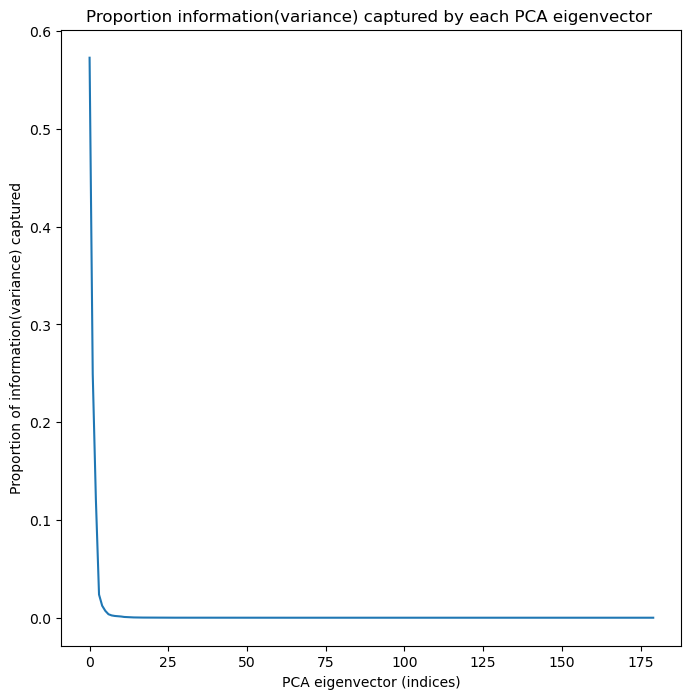

In [40]:
plt.plot(pca_function(s_embed_standard, 180)[2]/np.sum(pca_function(s_embed_standard, 180)[2]))
plt.xlabel('PCA eigenvector (indices)')
plt.ylabel('Proportion of information(variance) captured')
plt.title('Proportion information(variance) captured by each PCA eigenvector ')

Text(0.5, 1.0, 'A scatter plot of the coefficients of the first two Principal components')

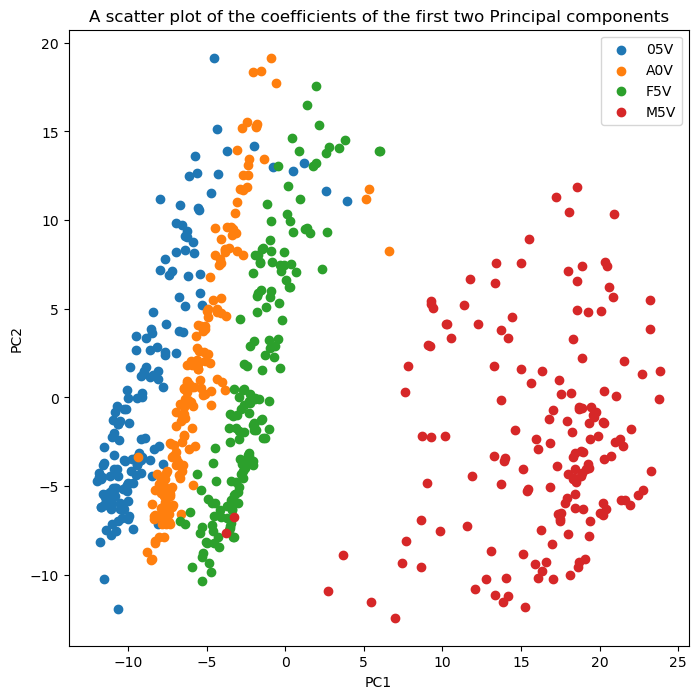

In [41]:
plt.scatter(X_pca[indices_0, 0], X_pca[indices_0, 1], label='05V')
plt.scatter(X_pca[indices_1, 0], X_pca[indices_1, 1], label='A0V')
plt.scatter(X_pca[indices_2, 0], X_pca[indices_2, 1], label='F5V')
plt.scatter(X_pca[indices_3, 0], X_pca[indices_3, 1], label='M5V')
#plt.scatter(X_pca[n_datapoints:X.shape[0], 0], X_pca[n_datapoints:X.shape[0], 1], label='Digit 7')
plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('A scatter plot of the coefficients of the first two Principal components')

First, it is important to note that the reduced data captures 82% of the information(variance) from the original data and as we have captured a signifcant portion of the information from our data set using these principal components, any identified trends can be considered significant in classificatiou.

Plotting the projection onto the first two Principal components, we observe that the PC1 is significantly better at distinguishing between clusters(classes) compared to PC2. However, looking at classes: O5V, A0V and F5V we observe that there is low cluster seperation between them in terms of PC1 but there is a high degree of cluster seperation between class M5V and the other classes. Alternatively, PC2 shows poor ability to classify the data in any capacity however when using the two principal componenets together we observe that classes O5V A0V and F5V exhibit oval clustering whilst M5V exhibits more spherical clustering. 

Going back to how PC1 reflects most of the clustering within our data, this may be further explained by noting that PC1 alone captures over 50% of the information(variance) of our data set.

One point worth mentioning is that PC1 may be capturing information regarding the temperature of the star by taking into account the classification of our stars and what each class represents. Our PC1 projection somewhat follows the idea that O<A<F<M (first letter of the class names) which follows the temperature classification convention used (M being the coolest and O being the hottest).

Define a function that computes the Davies-Bouldin Index

In [42]:
# Define a function that computes centroids
def compute_centroids(kc, X, labels):
    """
    Compute the centroids of the clustered points X.

    Args:
        kc (int): total number of clusters.
        X (np.ndarray): data points, with shape (N, p)
        labels (np.ndarray): cluster assignments for each sample in X, with shape (N,).

    Returns:
        (np.ndarray): the centroids of the k clusters, with shape (k, p).
    """
    N, p = X.shape

    centroids = np.zeros((kc, p))


    for label in range(kc):
        # find points in this cluster
        cluster_X_l = X[labels==label] 

        # Compute centroid of this cluster
        centroids[label] = np.sum(cluster_X_l, axis = 0)/len(cluster_X_l)

    return centroids

#Define a function that computes the distance between two centroids
def centroid_distance(centroid,a,b):
    """
    Compute the distances between two centroids

    Args:
        centroids: an array containing the centroids of each cluster
        a: index of one of the centroids to compute the distance between
        b : index of the other centroids to compute the distance between

    Returns:
        (np.ndarray): the distance between the two indexed centroids
    """

    return np.linalg.norm(centroid[b]-centroid[a])

# Define a function that computes the average distances between points in a cluster and the centroid of that cluster
def avg_dist_centroid(kc,X,labels,centroids):
    """
    Compute the centroids of the clustered points X.

    Args:
        kc (int): total number of clusters.
        X (np.ndarray): data points, with shape (N, p)
        labels (np.ndarray): cluster assignments for each sample in X, with shape (N,)
        centroids: an array containing the centroids of each cluster

    Returns:
        (np.ndarray): the average distances between points in a cluster and that clusters centroid
    """

    distances = np.zeros(kc)
    for i in range(kc):
        c = centroids[i]
        # compute average distance for cluster i
        distance_temp = np.mean( np.linalg.norm(X[labels==i]-c, axis = 1))

        # include this computed average distance in our distance vector
        distances[i] = distance_temp

    return distances

# Define a function that returns the Davies-Bouldin Index
def db_index(kc,X,labels):
    """
    Compute the centroids of the clustered points X.

    Args:
        kc (int): total number of clusters.
        X (np.ndarray): data points, with shape (N, p)
        labels (np.ndarray): cluster assignments for each sample in X, with shape (N,).

    Returns:
        the Davies-Boulin index
    """
    
    # initialise data
    dbi = 0

    centroids = compute_centroids(kc,X,labels)

    avg_cen_dist = avg_dist_centroid(kc,X,labels,centroids)

    for i in np.arange(kc):
        not_class = np.delete(np.arange(kc), i)
        val = 0

        for j in not_class:
            cent_dist = centroid_distance(centroids,i,j)

            temp_val = (avg_cen_dist[i] + avg_cen_dist[j])/cent_dist

            if temp_val > val:
                val = temp_val

        dbi+=val

    return dbi/4

Compute the DB index

In [43]:
DB_Index_check = db_index(4,X_pca ,s_class_train)
print('the DB Index is:',DB_Index_check)

the DB Index is: 2.8533698550985886


The Davies-Bouldin Index calculates a ratio between the cluster dispersion(how far the points in a cluster are from their centroid) and the cluster seperation(how far the centroids of different clusters are from one another). This effectively gives us a measure of how distinct our clusters are with lower values intuitively telling us we have a high degree of distinction between clusters while higher values tell us we don't have much distinction between clusters.  We have a DB index of 2.85 suggesting our clustering isn't overly good at discriminating between clusters. 

Examining the projection of our values onto the first two principal components we observe that while we don't particularily have a high degree of cluster seperation between the clusters (in particular 05V,A0V,F5V). however we do have noticable the distinctions between the clusters upon examining our graph(not ideal but it is noticeable). This can be explained by noting that while PC1 does differentiate between clusters, PC2 doesn't. Thus we have high cluster spread in terms of the PC2 coefficients and low cluster spread in terms of the PC1 components (resulting in oval clustering as opposed to spherical clustering). But this high cluster spread in terms of the PC2 components is compounded with the low cluster seperation (in terms of the aforementioned 3 classes) resulting in a relatively bad DB index(due to it effectively attempting to spherical clustering). Thus while the DB index gives some idea of our cluster seperation it doesn't give us the full picture due to the shape of our clusters. This idea regarding the shape of our clusters is further developed by noting that the DB index effectively assumes our clsuters take on a spherical/circular shape, however the clusters observed by our plots appear to follow more ovular clustering.



---



<a name="task-22"></a>

## (2.2) [(index)](#index-task-22)

In this question we shall utilise the Laplacian along with the cosine distance metric to attempt to identify clustering behaviour. In particular our graph will be determined using k-nearest neighbours to better identify local patterns using cosine distance. We shall examine the behaviour in the following plots at the end of this section.

In [44]:
X = s_embed_train.copy()

Construct the Distances matrix

In [45]:
numerator = X@X.T

norms2 = np.sqrt(np.diag(numerator))

denominator = norms2[:,np.newaxis]@norms2[np.newaxis,:]

Dist_mat = 1 - numerator/denominator

truth =  np.isinf(Dist_mat)

Dist_mat = np.where((truth==0)|(truth==1), truth^1, truth)*Dist_mat


Construct the weighted Adjacency matrix

In [46]:
knnk = 9
N = Dist_mat.shape[0]

A = np.zeros((N,N))
#print(A.shape)

for i in range(len(A)):
    # find ordered indices of nearest neighbours 
    ord_neigh_index = np.argsort(Dist_mat[i])
    

    # select the k nearest neighbours and itself
    ord_neigh_index = ord_neigh_index[:knnk+1]
    #print(ord_neigh_index)

    # set the ijth value = 1 if node j is within the k nearest neighbours of node i
    A[i][ord_neigh_index] = 1
    #print(A.shape)

# but we need to account for a connection if j is within the k nearest neighbours of i aswell
    # Find all places where we want a value 1 
indices = (A+A.T > 0)

# Set a value of one to all the indexed points above
A[indices] = 1

# replace diagonal elements 
np.fill_diagonal(A,0)

Aw = Dist_mat*A
np.count_nonzero(A)

7408

Compute the Combinatorial Laplacian and the Symmetric Normalised Laplacian

In [47]:
# define diagonal degree matrix
d = np.sum(Aw,axis=0)

D = np.diag(d)     

# compute combinatorial Laplacian
L = D - Aw          

# compute square root of inverse diagonal degree matrix
D_sqrt_inv = np.diag(1/np.sqrt(d)) 

# compute symmetric normalised Laplacian
L_s = D_sqrt_inv @ L @ D_sqrt_inv   

Compute and sort eigenvalues and eigenvectors of the Symmetric normalised Laplacian

In [48]:
# compute eigen decomposition of the symmetric normalised Laplacian
eigenvals, eigenvecs = np.linalg.eigh(L_s)   

# sort eigenvalues and corresponding eigenvector
eigenvecs = eigenvecs.T[np.argsort(eigenvals)] 
eigenvals = np.sort(eigenvals)            

In [49]:
v2 = eigenvecs[1]      
v3 = eigenvecs[2]      

# normalise coordinates
x = D_sqrt_inv @ v2    
y = D_sqrt_inv @ v3   

Plot the Normalised Fieldler eigenvector against the Normalised Third eigenvector

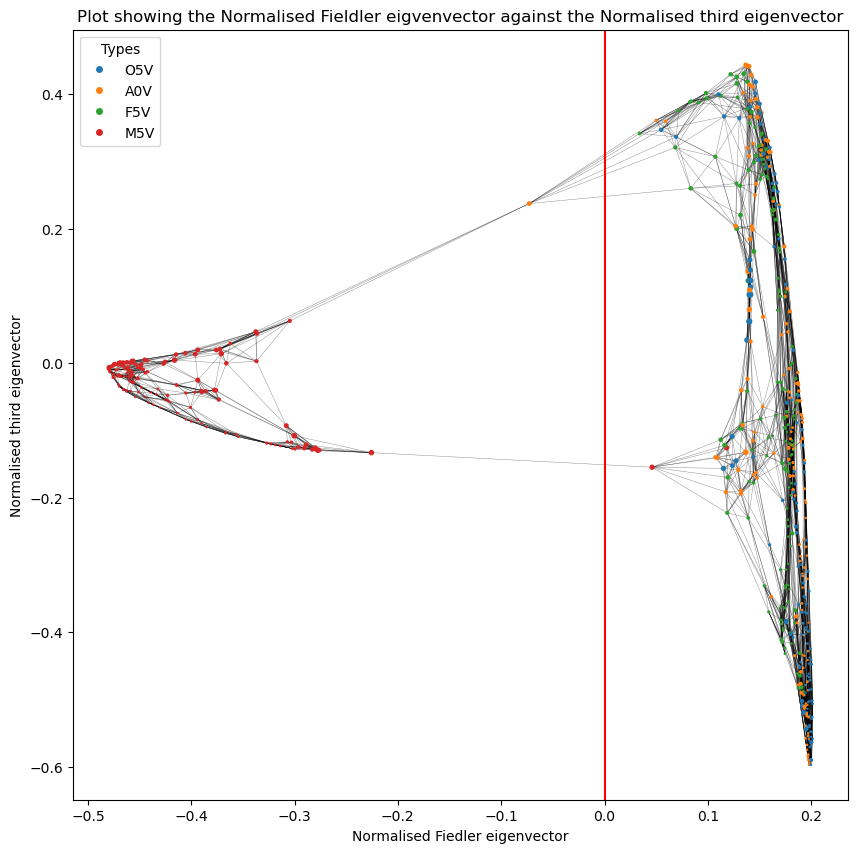

In [50]:
# plot
fig, ax = plt.subplots(1,figsize = (10,10))

# plot edges
for i in range(D.shape[0]):
    for j in range(i+1,D.shape[0]):
        if A[i,j] > 0:
            ax.plot([x[i],x[j]],[y[i],y[j]], color="black", alpha=0.5, linewidth=0.3)

# plot nodes
scatter = ax.scatter(x,y,s=100*d, c=color_type, zorder=10)

# create legend for node types
types_legend = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=cmap2(value)) for value, label in value_to_type.items()]
plt.legend(handles=types_legend, title='Types')

# plot cut induced by Fiedler eigenvector
ax.axvline(x=0, color = "red")

# title the plot
plt.title('Plot showing the Normalised Fieldler eigvenvector against the Normalised third eigenvector')


# set labels
ax.set(xlabel="Normalised Fiedler eigenvector", ylabel="Normalised third eigenvector")
plt.show()

The eigenvectors of the laplacian capture the structural properties of our graph.  In particular our graph has connections determined via each nodes k-Nearest Neighbours(k=9) when calculating distance via cosine distances (we have set an angle of 0 between vectors to be equal to 0 and an angle of 90 between vectors to be equal to 1, thus closer points under this distance measure have smaller angles between them). It is important to note that cosine similarity is irrespective of the magnitude of the vectors and is moreso a measure of whether data is proportional to one another. The eigenvectors of the Laplacian reflect different structural properties of the graph and by plotting them we can see if they contain any information regarding distinguishing between our clusters(classes).

The Fieldler eigenvector is the eigenvector associated with the smallest non-trivial eigenvalue and is a representative of the algebraic connectivity of the graph. We note that this eigenvector creates a near perfect bipartition by seperating class M5V for the other three classes (evidenced by our vertical line at 0). However we observe effectively no seperation in the other 3 classes when considering the Fielder eigenvector.

On the otherhand the normalised third eigenvector, while appearing to group the M5V class to 0, doesn't appear to restrict the other classes from taking values in this region and is thus ineffective at distinguishing between classes. It is also worth noting that this eigenvector should capture properties orthogonal to the Fiedler eigenvector and this categorisation of class M5V is seperate from how the Fiedler eigenvector categorised class M5V.

The inability to distinguish between classes may stem from how cosine similarity measures similarity in that it effectively considers how proportional the data is in comparison to other data vectors. This would suggest that the three classes 05V, A0V and F5V all have high cosine similarity and are somewhat proportional to one another when considering the information stored in our embeddings suggesting that in order to better understand how to classify these classes we must look at more non-linear approaches or approaches dependant on the magnitude of the data vectors..



---



<a name="task-22"></a>

## (2.3) [(index)](#index-task-23)

In this question we shall implement an Isomap inspired approach to potentially gain a better understanding of the 2D manifold on which our data lives. We shall compare our clustering and classifcation behaviour to that exhibited by PCA.

Compute Gamma and R matrices

In [51]:
Gamma = np.linalg.pinv(L - (1/N) * np.ones((N,N)))

R = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        R[i,j] = Gamma[i,i] + Gamma[j,j] - 2*Gamma[i,j]



Plot mean cosine distance vs Mean resistance distance

C:\Users\Work\AppData\Local\Temp\ipykernel_20208\1259784411.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(mean_cosine, mean_resistance, c=color_type, cmap='tab10', alpha=0.5, zorder =10)


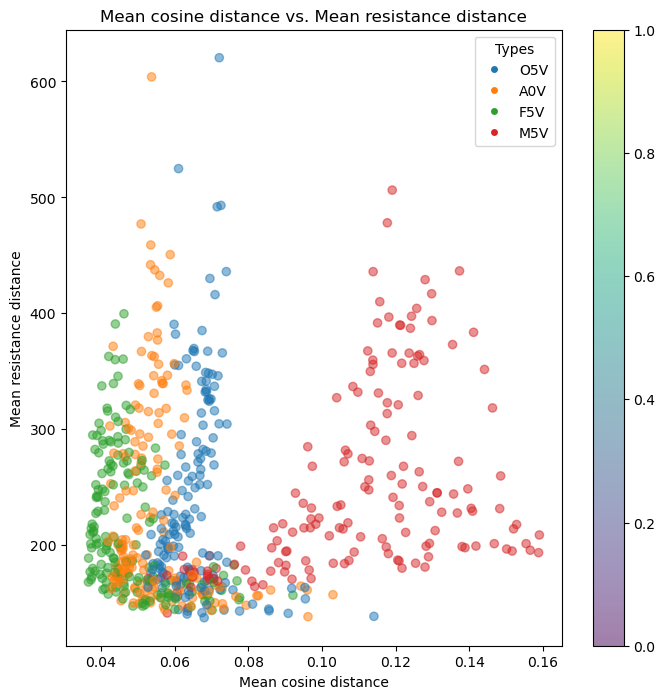

In [52]:
mean_cosine = np.sum(Dist_mat, axis=1) / (N-1)
mean_resistance = np.sum(R, axis=1) / (N-1)

plt.scatter(mean_cosine, mean_resistance, c=color_type, cmap='tab10', alpha=0.5, zorder =10)
plt.xlabel('Mean cosine distance')
plt.ylabel('Mean resistance distance')
plt.title('Mean cosine distance vs. Mean resistance distance')
plt.colorbar()
plt.legend(handles=types_legend, title='Types')
plt.show()

The above plot comparing mean cosine distance and Mean resistance distance show us that the mean cosine distance captures a information similar to PC1 in that it seperates M5V from the other classes albeit to a lesser degree than that of PC1. It may also be worth noting that this seperation also doesn't appear to be seperating based on temperature as the hottest and coolest classes(O5V and M5V) are positioned next to one another.

Mean resistance distance on the other hand appears to exhibit no ability to distinguish between classes.

Plot the 2D projection

C:\Users\Work\AppData\Local\Temp\ipykernel_20208\2283159423.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(eVecs_ord1[:,-1],eVecs_ord1[:,-2], c=color_type, cmap='tab10', alpha=0.5, zorder =10)


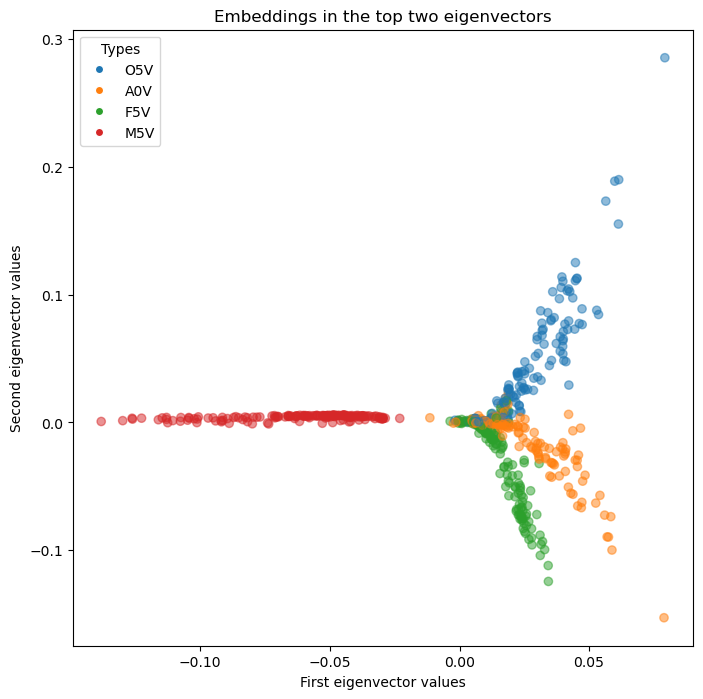

In [53]:
S = np.square(R)

H = np.identity(N) - (1/N) * np.ones((N,N))

tau = -H@S@H /2

# returns ordered eVals according to their absolute values
eVals, eVecs = np.linalg.eig(tau)

# order Evals from smallest to largest incorporating the positivity of the values
indices = np.argsort(eVals)

# ORder eigenvectors according to this new indexing
eVecs_ord1 = eVecs[:,indices]

#plot
plt.scatter(eVecs_ord1[:,-1],eVecs_ord1[:,-2], c=color_type, cmap='tab10', alpha=0.5, zorder =10)
plt.title('Embeddings in the top two eigenvectors')
plt.xlabel('First eigenvector values')#
plt.ylabel('Second eigenvector values')
plt.legend(handles=types_legend, title='Types')

Compute the DB Index of this projection

In [54]:
DB_Index_potato = db_index(4,eVecs_ord1[:,-2:],s_class_train)
print('The DB Index is:',DB_Index_potato)

The DB Index is: 1.936776787132891


First we outline that if our graph network is assumed to be a fully connected network and wth edge weights taking the euclidean distance associated with the original feature space, then PCA is equivalent to Isomap. 

Taking into account our Isomap-like algorithm we note that the first embedding differentiates between M5V and the other classes with M5V taking negative values and the other classes taking positive values, similar to the behaviour of PC1. This may similarly suggest that this embedding captures data related to the temperature of the star as explained in 2.1. Now we make a distincition between our PCA and our Isomap like algorithm in that PCA captures the underlying linearity meanwhile the Multidimensional-scaling in our Isomap-like algorithm captures the underlying 2d manifold which the data lies on which is in essence unrolled into 2 dimensions while preserving pairwise distances. Taking into consideration our second embedding we note that M5V appears to be isolated to around 0 while O5V takes positive values with the other two classes taking negative values. 

Noting that our earlier plot regarding local resistance data failed to capture any trends in the classes, while our second embedding has some degree of classification ability suggests that there exists some non-linear global manifold in the resistance distance seperating these nodes. The distinction between global and local is important as our earlier plot only gave information regarding the local resistance distance and didn't consider nodes that were 'far away' and not directly connected to one another whilst the plot above doesn't make this distinction. The suggestion that this captured property is non-linear comes from PCA's inability to detect it.

The more detailed clustering observed in the plot and explained above is also reflected by our DB index which is 1.9 compared to our PCA's DB index of 2.8. However, it is worth noting that while the DB Index is better, it doesn't necessarily constitute a 'good' DB index likely due to the low cluster seperation between O5V, A0V and F5V which is a problem that PCA also faced.





---

